In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import astral
from astral.sun import sun
import xarray as xr
import seaborn as sns
sns.set_theme() # Apply the default theme
import learning_lidar.utils.global_settings as gs
from learning_lidar.dataseting.dataseting_utils import query_database
from IPython.display import display
from learning_lidar.utils import vis_utils
vis_utils.set_visualization_settings()
def myround(x, base=5):
    return base * round(x/base)

# Compare calibrated values by Pollynet Processing Chain to GT values1
1. Load dataset_ALiDAn_Haifa.csv
2. Add columns of sun angle start/end for each period
3. Add columns: Pollynet_LC_<pollyType>, e.g.: Pollynet_LC_ALiDAn_signal_lidar, Pollynet_LC_ALiDAn_signal_p
4. Iterate over the table 'lidar_calibration_constant' of each pollyType

In [2]:
# Read Pollynet proccesing chain results:
Pollynet_Processing_Chain_directory = os.path.join(os.path.dirname(gs.PKG_ROOT_DIR),'Pollynet_Processing_Chain')
station_file = os.path.join(Pollynet_Processing_Chain_directory,'config',f'pollynet_processing_chain_config_links.xlsx')
station_df = pd.read_excel(station_file)
station_info = station_df[station_df.Instrument=='ALiDAn']
timezone = 'UTC'
loc = astral.LocationInfo("Haifa",'Israel',timezone,station_info.Latitude,station_info.Longitude)
loc.observer.elevation = station_info['asl.']

In [3]:
# Read ALiDAn Ground Truth dataset
GT_db_path = r'C:\Users\addalin\Dropbox\Lidar\lidar_learning\data\dataset_ALiDAn_Haifa.csv'
ALiDAn_df = pd.read_csv(GT_db_path)
# convert time columns to timestamp
ALiDAn_df['start_time_period'] = pd.to_datetime(ALiDAn_df['start_time_period'],format='%m/%d/%Y %H:%M')
ALiDAn_df['end_time_period'] = pd.to_datetime(ALiDAn_df['end_time_period'],format='%m/%d/%Y %H:%M')+ pd.Timedelta(seconds=30)
ALiDAn_df.wavelength=ALiDAn_df.wavelength.astype('str')

# Add sun elevation angles for start/end time
time_start_utc = [pd.Timestamp(dt).tz_localize(timezone) for dt in ALiDAn_df.start_time_period]
ALiDAn_df['sun_elevation_start'] = [astral.sun.elevation(loc.observer,dt) for dt in time_start_utc]
time_end_utc = [pd.Timestamp(dt).tz_localize(timezone) for dt in ALiDAn_df.end_time_period]
ALiDAn_df['sun_elevation_end'] = [astral.sun.elevation(loc.observer,dt) for dt in time_end_utc]
ALiDAn_df['sun_elevation_mid'] = 0.5*(ALiDAn_df['sun_elevation_end']+ALiDAn_df['sun_elevation_start'])
ALiDAn_df['diff_angle'] = (ALiDAn_df['sun_elevation_end']-ALiDAn_df['sun_elevation_start'])
ALiDAn_df['quant_angle'] = myround(ALiDAn_df['sun_elevation_mid'],base=5)
ALiDAn_df['sample_idx'] = ALiDAn_df.index.values
ALiDAn_df

date wavelength   start_time_period     end_time_period  \
0        4/1/2017        355 2017-04-01 00:00:00 2017-04-01 00:29:30   
1        4/1/2017        355 2017-04-01 00:30:00 2017-04-01 00:59:30   
2        4/1/2017        355 2017-04-01 01:00:00 2017-04-01 01:29:30   
3        4/1/2017        355 2017-04-01 01:30:00 2017-04-01 01:59:30   
4        4/1/2017        355 2017-04-01 02:00:00 2017-04-01 02:29:30   
...           ...        ...                 ...                 ...   
17563  10/31/2017       1064 2017-10-31 21:30:00 2017-10-31 21:59:30   
17564  10/31/2017       1064 2017-10-31 22:00:00 2017-10-31 22:29:30   
17565  10/31/2017       1064 2017-10-31 22:30:00 2017-10-31 22:59:30   
17566  10/31/2017       1064 2017-10-31 23:00:00 2017-10-31 23:29:30   
17567  10/31/2017       1064 2017-10-31 23:30:00 2017-10-31 23:59:30   

                                                 bg_path  \
0      GENERATION\bg_dataset\2017\04\2017_04_01_00000...   
1      GENERATION\bg_dataset\2017\04\2017_04_01_00300...   
2      GENERATION\bg_dataset\2017\04\2017_04_01_01000...   
3      GENERATION\bg_dataset\2017\04\2017_04_01_01300...   
4      GENERATION\bg_dataset\2017\04\2017_04_01_02000...   
...                                                  ...   
17563  GENERATION\bg_dataset\2017\10\2017_10_31_21300...   
17564  GENERATION\bg_dataset\2017\10\2017_10_31_22000...   
17565  GENERATION\bg_dataset\2017\10\2017_10_31_22300...   
17566  GENERATION\bg_dataset\2017\10\2017_10_31_23000...   
17567  GENERATION\bg_dataset\2017\10\2017_10_31_23300...   

                                              lidar_path  \
0      GENERATION\lidar_dataset\2017\04\2017_04_01_00...   
1      GENERATION\lidar_dataset\2017\04\2017_04_01_00...   
2      GENERATION\lidar_dataset\2017\04\2017_04_01_01...   
3      GENERATION\lidar_dataset\2017\04\2017_04_01_01...   
4      GENERATION\lidar_dataset\2017\04\2017_04_01_02...   
...                                                  ...   
17563  GENERATION\lidar_dataset\2017\10\2017_10_31_21...   
17564  GENERATION\lidar_dataset\2017\10\2017_10_31_22...   
17565  GENERATION\lidar_dataset\2017\10\2017_10_31_22...   
17566  GENERATION\lidar_dataset\2017\10\2017_10_31_23...   
17567  GENERATION\lidar_dataset\2017\10\2017_10_31_23...   

                                             signal_path  \
0      GENERATION\signal_dataset\2017\04\2017_04_01_0...   
1      GENERATION\signal_dataset\2017\04\2017_04_01_0...   
2      GENERATION\signal_dataset\2017\04\2017_04_01_0...   
3      GENERATION\signal_dataset\2017\04\2017_04_01_0...   
4      GENERATION\signal_dataset\2017\04\2017_04_01_0...   
...                                                  ...   
17563  GENERATION\signal_dataset\2017\09\2017_09_02_0...   
17564  GENERATION\signal_dataset\2017\09\2017_09_02_0...   
17565  GENERATION\signal_dataset\2017\09\2017_09_02_0...   
17566  GENERATION\signal_dataset\2017\09\2017_09_02_0...   
17567  GENERATION\signal_dataset\2017\09\2017_09_02_0...   

                                           signal_p_path  \
0      GENERATION\signal_dataset\2017\04\2017_04_01_0...   
1      GENERATION\signal_dataset\2017\04\2017_04_01_0...   
2      GENERATION\signal_dataset\2017\04\2017_04_01_0...   
3      GENERATION\signal_dataset\2017\04\2017_04_01_0...   
4      GENERATION\signal_dataset\2017\04\2017_04_01_0...   
...                                                  ...   
17563  GENERATION\signal_dataset\2017\09\2017_09_01_1...   
17564  GENERATION\signal_dataset\2017\09\2017_09_01_1...   
17565  GENERATION\signal_dataset\2017\09\2017_09_01_1...   
17566  GENERATION\signal_dataset\2017\09\2017_09_01_1...   
17567  GENERATION\signal_dataset\2017\09\2017_09_01_1...   

                                          molecular_path  \
0      DATA FROM TROPOS\molecular_dataset\2017\04\201...   
1      DATA FROM TROPOS\molecular_dataset\2017\04\201...   
2      DATA FROM TROPOS\molecular_dataset\2017\04\201...   
3      DATA FROM TROPOS\

In [4]:
wavelengths =[355,532,1064]
fig_type = 'svg'
polly_results_path = os.path.join(Pollynet_Processing_Chain_directory,'results_new')
for ALiDAn_type in ['lidar']: #'signal_p','lidar'
    pollyType = 'ALiDAn' if ALiDAn_type=='lidar' else 'ALiDAn_'+ALiDAn_type
    #print(pollyType)
    database_path = os.path.join(polly_results_path,pollyType, 'ALiDAn_calibration.db')
    print(database_path)
    Pollynet_df = query_database( database_path=database_path)
    Pollynet_df= Pollynet_df.drop(columns=['id'])
    display(Pollynet_df)

c:\users\addalin\dropbox\lidar\Pollynet_Processing_Chain\results_new\ALiDAn\ALiDAn_calibration.db


cali_start_time      cali_stop_time       liconst  \
0    2017-04-01 00:30:00 2017-04-01 00:59:30  1.702766e+13   
1    2017-04-01 01:30:00 2017-04-01 01:59:30  1.769301e+13   
2    2017-04-01 02:30:00 2017-04-01 02:59:30  1.836673e+13   
3    2017-04-01 03:00:00 2017-04-01 03:29:30  1.864629e+13   
4    2017-04-01 03:30:00 2017-04-01 03:59:30  1.895538e+13   
...                  ...                 ...           ...   
2268 2017-10-11 17:30:00 2017-10-11 17:59:30  7.766710e+13   
2269 2017-10-11 18:30:00 2017-10-11 18:59:30  3.080107e+13   
2270 2017-10-11 22:00:00 2017-10-11 22:29:30  3.476513e+13   
2271 2017-10-11 18:30:00 2017-10-11 18:59:30  7.981412e+13   
2272 2017-10-11 22:00:00 2017-10-11 22:29:30  5.893454e+13   

      uncertainty_liconst wavelength  \
0            5.711823e+09        355   
1            6.333888e+09        355   
2            5.953795e+09        355   
3            7.035209e+09        355   
4            7.160679e+09        355   
...                   ...        ...   
2268         3.927057e+10       1064   
2269         1.582634e+10        532   
2270         1.830747e+10        532   
2271         7.111586e+10       1064   
2272         3.548480e+10       1064   

                                            nc_zip_file polly_type  \
0     D:\data_haifa\GENERATION\lidar_dataset_to_poll...     ALiDAn   
1     D:\data_haifa\GENERATION\lidar_dataset_to_poll...     ALiDAn   
2     D:\data_haifa\GENERATION\lidar_dataset_to_poll...     ALiDAn   
3     D:\data_haifa\GENERATION\lidar_dataset_to_poll...     ALiDAn   
4     D:\data_haifa\GENERATION\lidar_dataset_to_poll...     ALiDAn   
...                                                 ...        ...   
2268  D:\data_haifa\GENERATION\lidar_dataset_to_poll...     ALiDAn   
2269  D:\data_haifa\GENERATION\lidar_dataset_to_poll...     ALiDAn   
2270  D:\data_haifa\GENERATION\lidar_dataset_to_poll...     ALiDAn   
2271  D:\data_haifa\GENERATION\lidar_dataset_to_poll...     ALiDAn   
2272  D:\data_haifa\GENERATION\lidar_dataset_to_poll...     ALiDAn   

       cali_method  telescope  
0     Klett_Method  far_range  
1     Klett_Method  far_range  
2     Klett_Method  far_range  
3     Klett_Method  far_range  
4     Klett_Method  far_range  
...            ...        ...  
2268  Klett_Method  far_range  
2269  Klett_Method  far_range  
2270  Klett_Method  far_range  
2271  Klett_Method  far_range  
2272  Klett_Method  far_range  

[2273 rows x 9 columns]

In [5]:
# Calling merge() function
int_df = pd.merge(ALiDAn_df, Pollynet_df, how ='inner',
                  left_on= ['start_time_period', 'end_time_period','wavelength'],
                  right_on=['cali_start_time', 'cali_stop_time','wavelength'])
int_df['err'] = int_df['liconst']-int_df['LC (photons sr m^3)']
int_df['relative_err']= 100*int_df.err/int_df['LC (photons sr m^3)']
int_df['absolute_relative_err']= 100*np.absolute(int_df.err)/int_df['LC (photons sr m^3)']
int_df['wavelength'] = int_df['wavelength'].astype(int)
drop_collumns = ['bg_path','lidar_path','signal_path','signal_p_path','molecular_path','cali_start_time','cali_stop_time','nc_zip_file']
int_df = int_df.set_index('sample_idx').drop(columns=drop_collumns, index=1)
#int_df

In [6]:
group_wavelengths = int_df.groupby(['wavelength'])
ds_wavelengths =[]
for grp_wavelength in group_wavelengths:
    wavelength = grp_wavelength[0]
    wav_int_df = int_df[int_df['wavelength']==wavelength]
    ds_clibs = []
    groups_calib = wav_int_df.groupby(['cali_method','polly_type','telescope'])
    for grp_calib in groups_calib:
        (cali_method,polly_type, telescope) = grp_calib[0]
        cali_method= cali_method.replace("_Method","")
        sub_df = grp_calib[1].drop(['cali_method','polly_type','telescope','wavelength'], axis=1)
        ds_cat = xr.Dataset(
                data_vars={ 'SampleIndex':('Index', sub_df.index.values),
                            'StartTime':('Index', sub_df['start_time_period'],
                                         {'info':'Start time of sample period'}),
                            'EndTime':('Index', sub_df['end_time_period'],
                                       {'info':'End time of sample period'}),
                            'LC': ('Index', sub_df['LC (photons sr m^3)'],
                                   {'info':'Ground truth lidar constant', 'long_name': r'$p_{\rm LC}^{\rm GT}$', 'units': r'$\rm photons \cdot sr \cdot m^3$'}),
                            'SunStart': ('Index', sub_df['sun_elevation_start'],
                                         {'info':'Sun angle at start time', 'long_name': r'$\alpha_{\rm SUN}^{\rm s}$', 'units': r'$\circ$'}),
                            'SunMid': ('Index', sub_df['sun_elevation_mid'],
                                     {'info':'Sun angle at middle time', 'long_name': r'$\alpha_{\rm SUN}^{\rm m}$', 'units': r'$\circ$'}),
                            'SunEnd': ('Index', sub_df['sun_elevation_end'],
                                     {'info':'Sun angle at end time', 'long_name': r'$\alpha_{\rm SUN}^{\rm e}$', 'units': r'$\circ$'}),
                            'DiffAngle': ('Index', sub_df['diff_angle'],
                                     {'info':'Sun angle differences of sample time perid', 'long_name': r'$\Delta\alpha_{\rm SUN}$', 'units': r'$\circ$'}),
                            'QAngle': ('Index', sub_df['quant_angle'],
                                     {'info':'Quant Sun angle', 'long_name': r'$\alpha_{\rm SUN}^{\rm q}$', 'units': r'$\circ$'}),
                            'EstimatedLC': ('Index', sub_df['liconst'],
                                     {'info':'Estimated lidar constant',
                                      'long_name':  r'$\tilde{p}_{\rm LC}$', 'units': r'$\rm photons \cdot sr \cdot m^3$'}),
                            'UncertainLC': ('Index', sub_df['uncertainty_liconst'],
                                     {'info':'Uncertainty of estimated lidar constant',
                                      'long_name':  r'$\sigma_{\tilde{p}_{\rm LC}}$', 'units': r'$\rm photons sr m^3$'}),
                            'Err': ('Index', sub_df['err'],
                                     {'info':'Difference between GT and estimated lidar constant',
                                      'long_name':  r'$\epsilon p_{\rm LC}$', 'units': r'$\rm photons sr m^3$'}),
                            'RelErr': ('Index', sub_df['relative_err'],
                                     {'info':'Normalized difference between GT and estimated lidar constant',
                                      'long_name':  r'$\epsilon_{\rm LC}^{\rm norm}$', 'units': r'$\%$'}),
                            #'Wavelength': int(wavelength),
                            'Source': ALiDAn_type,
                            'Method': cali_method,
                            #'wav': wavelength,
                            },
                coords={'Index': sub_df.reset_index().index,
                        })
        ds_clibs.append(ds_cat)
    ds_wav = xr.concat(ds_clibs,dim='Method')

    ds_wav=ds_wav.assign({'Wavelength':wavelength, 'long_name':r'$\lambda$','units': r'$[\rm nm]$', 'long_name':r'$\lambda$'})
    ds_wavelengths.append(ds_wav)
ds_results = xr.concat(ds_wavelengths,dim='Wavelength')


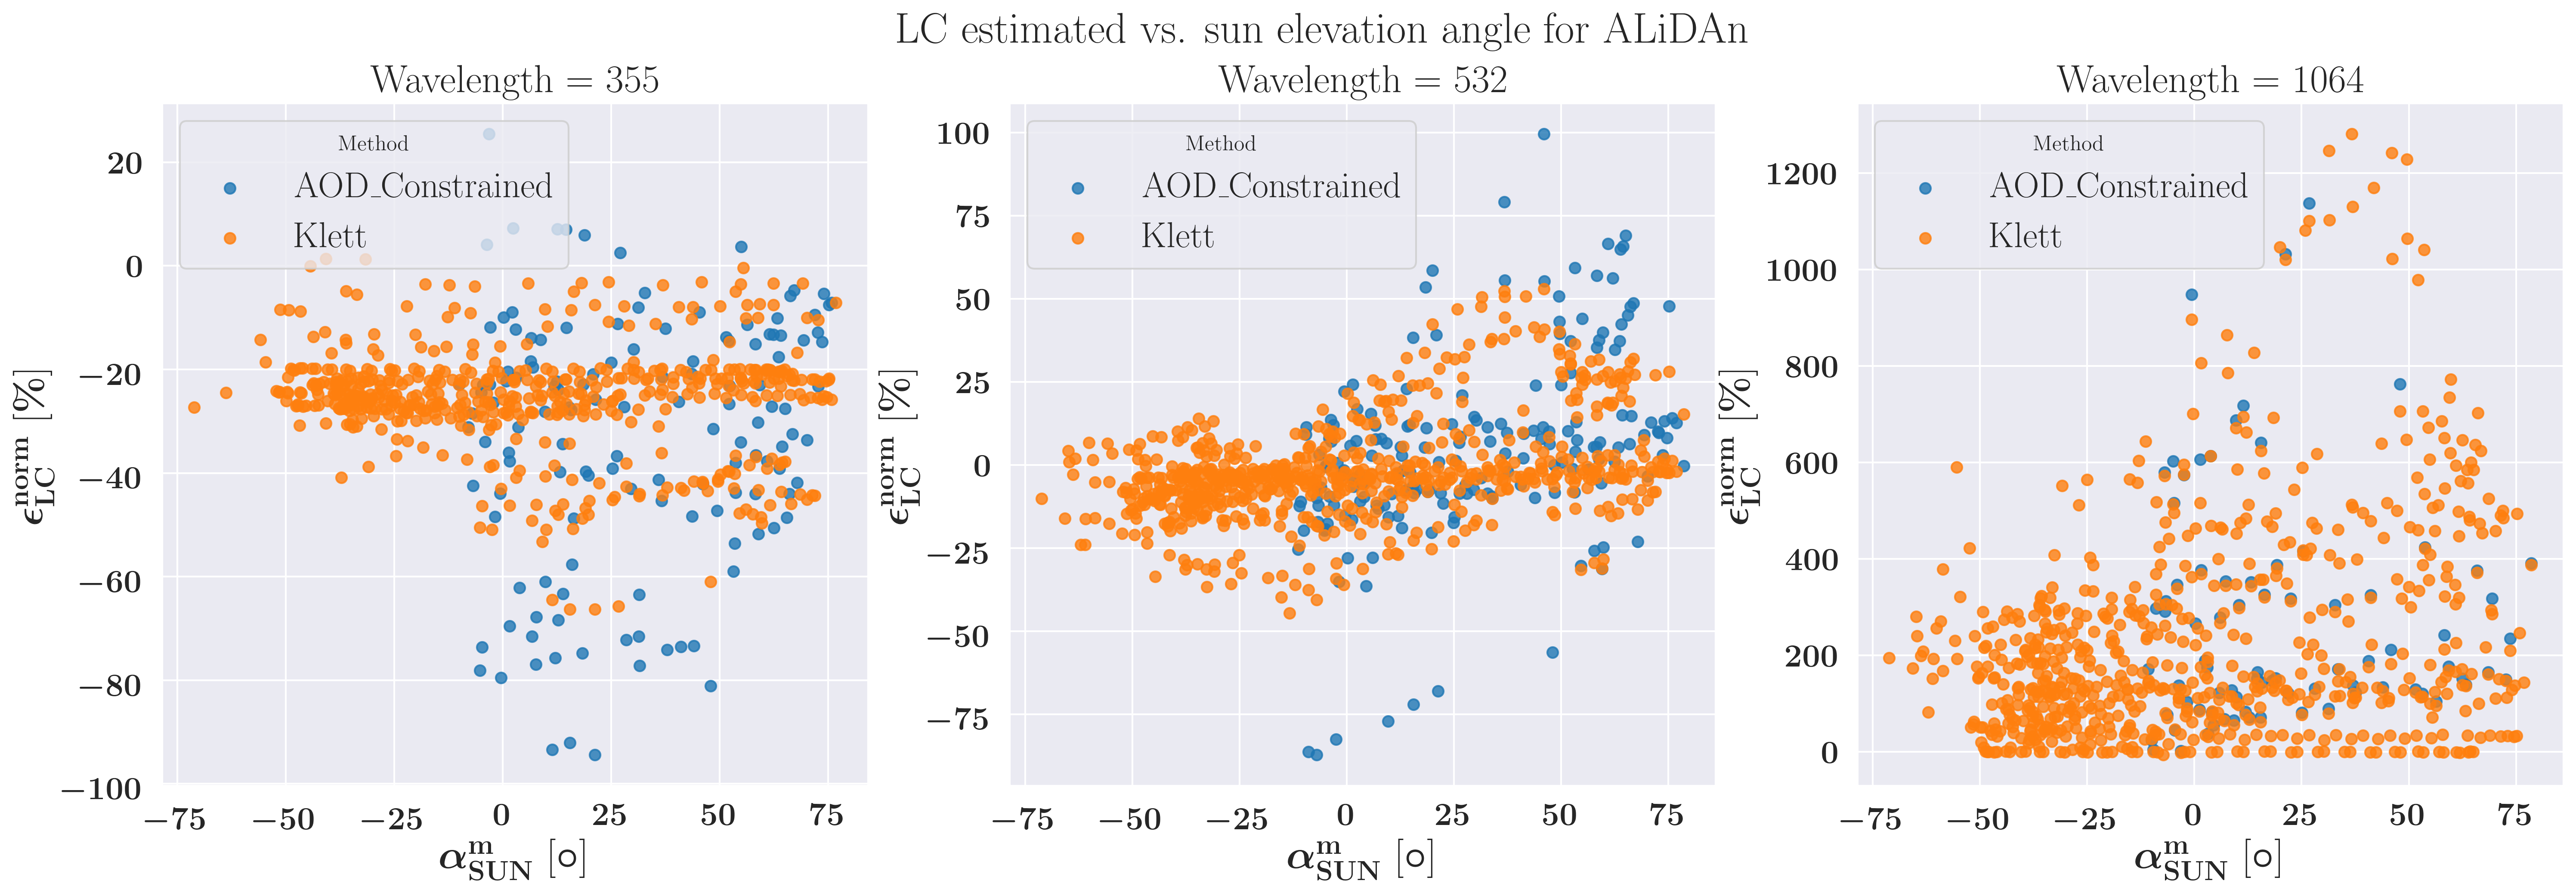

In [7]:
sns.set_palette(sns.color_palette("tab10"))
fig,axes = plt.subplots(nrows=1, ncols=len(wavelengths), figsize=(24,7))
for wavelength, ax in zip(wavelengths, axes.ravel()):
    ds_results.sel(Wavelength=wavelength).plot.scatter(x='SunMid',y='RelErr',
                        hue='Method', ax=ax , alpha=0.8 )
stitle_scatter = f'LC estimated vs. sun elevation angle for {pollyType}'
plt.suptitle(stitle_scatter)
plt.tight_layout
plt.show()
fpath =f"{stitle_scatter.replace('.','')}.{fig_type}"
fig.savefig(fpath, bbox_inches='tight', format=fig_type, dpi=1000)

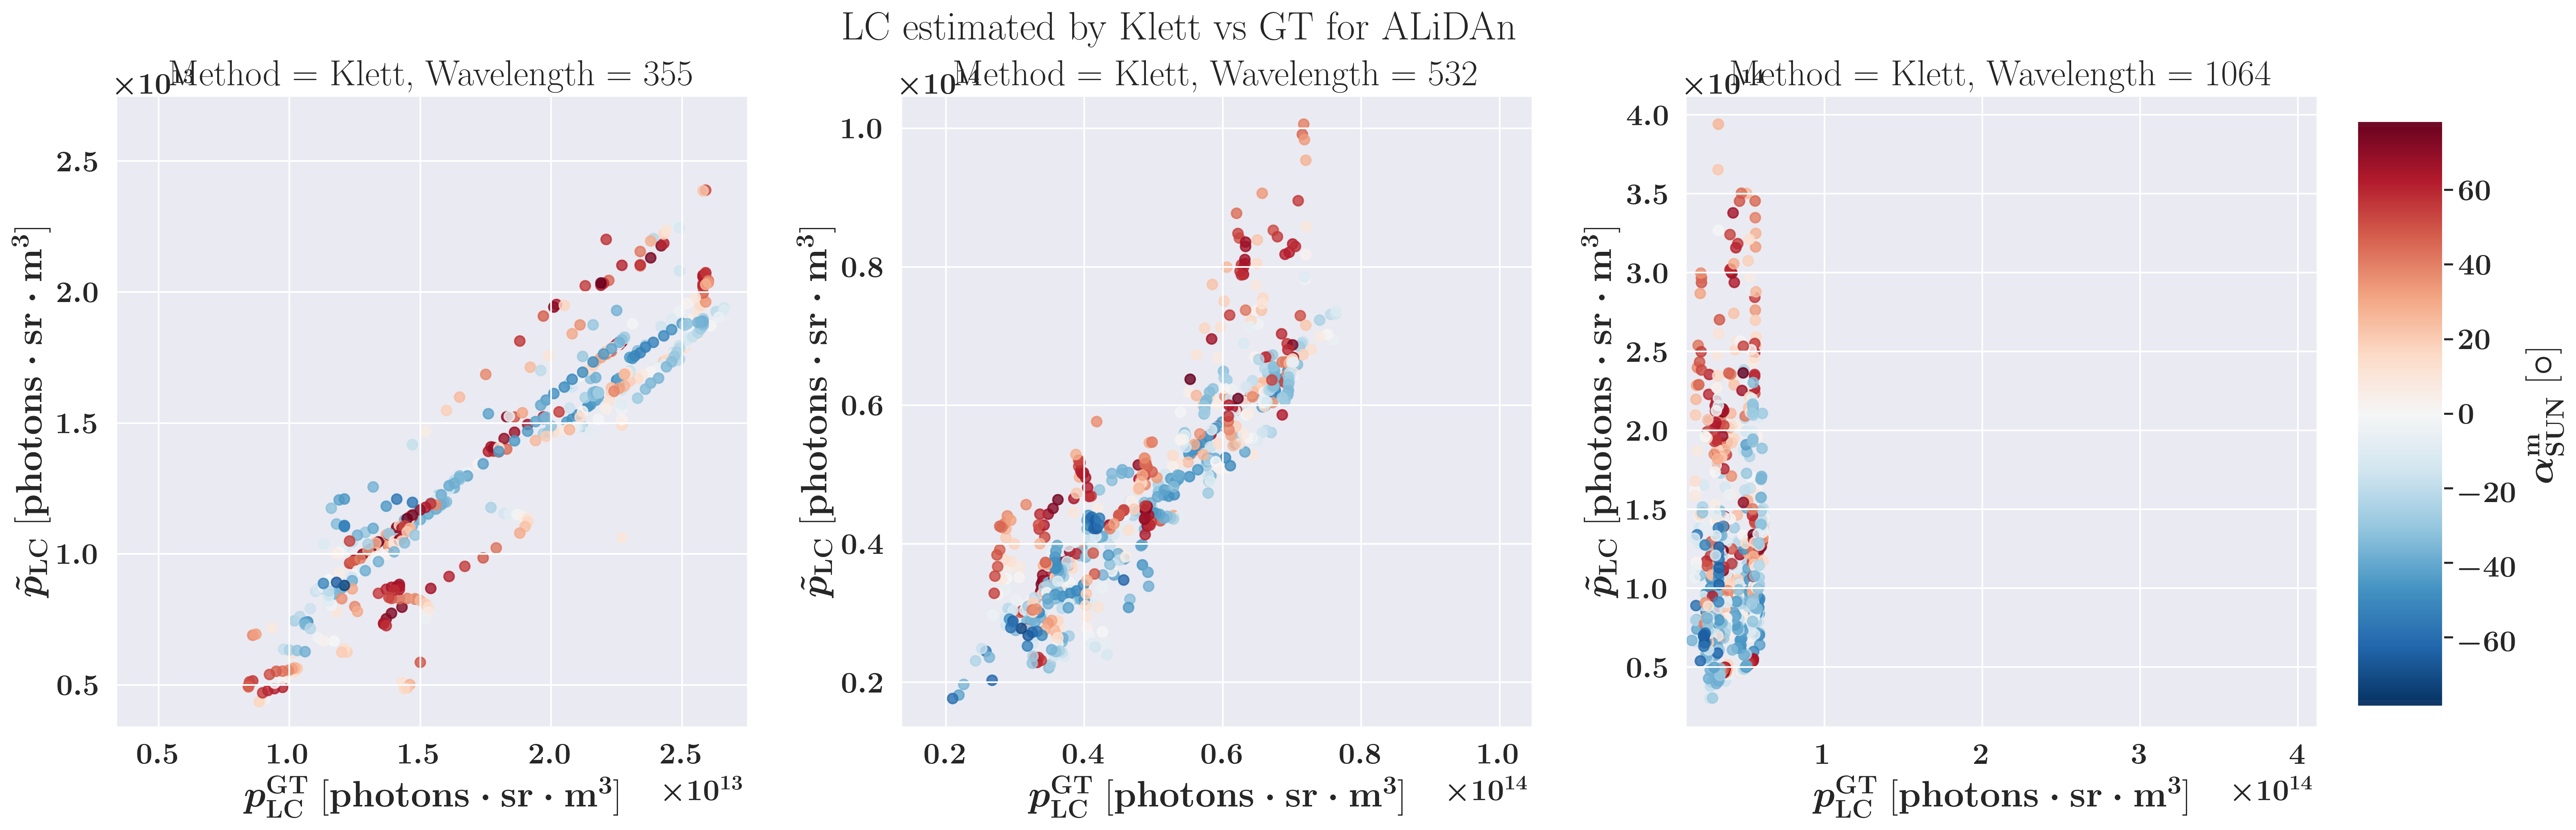

In [8]:
sns.set_palette(sns.color_palette("Spectral_r"))
fig,axes = plt.subplots(nrows=1, ncols=len(wavelengths), figsize=(24,7))
for col_index,(wavelength, ax) in enumerate(zip(wavelengths, axes.ravel())):
    if col_index == 0:
                cbar_ax = fig.add_axes([.91, .15, .03, .7])
    ds_results.sel(Wavelength=wavelength, Method=cali_method.replace('_Method','')).plot.scatter(x='LC',y='EstimatedLC',
                        hue='SunMid', ax=ax , alpha=0.8,cbar_ax=cbar_ax,zorder=-20)
    ax.set_rasterization_zorder(-10)
    xlim= ax.get_xlim()
    ylim= ax.get_ylim()
    min_val = min(xlim[0],ylim[0])
    max_val = max(xlim[1],ylim[1])
    ax.set_xlim([min_val,max_val])
    ax.set_ylim([min_val,max_val])
    ax.set_aspect('equal')
stitle = f'LC estimated by {cali_method} vs GT for {pollyType}'
plt.suptitle(stitle)
plt.show()
fpath =f'{stitle}.{fig_type}'
fig.savefig(fpath, bbox_inches='tight', format=fig_type, dpi=1000)

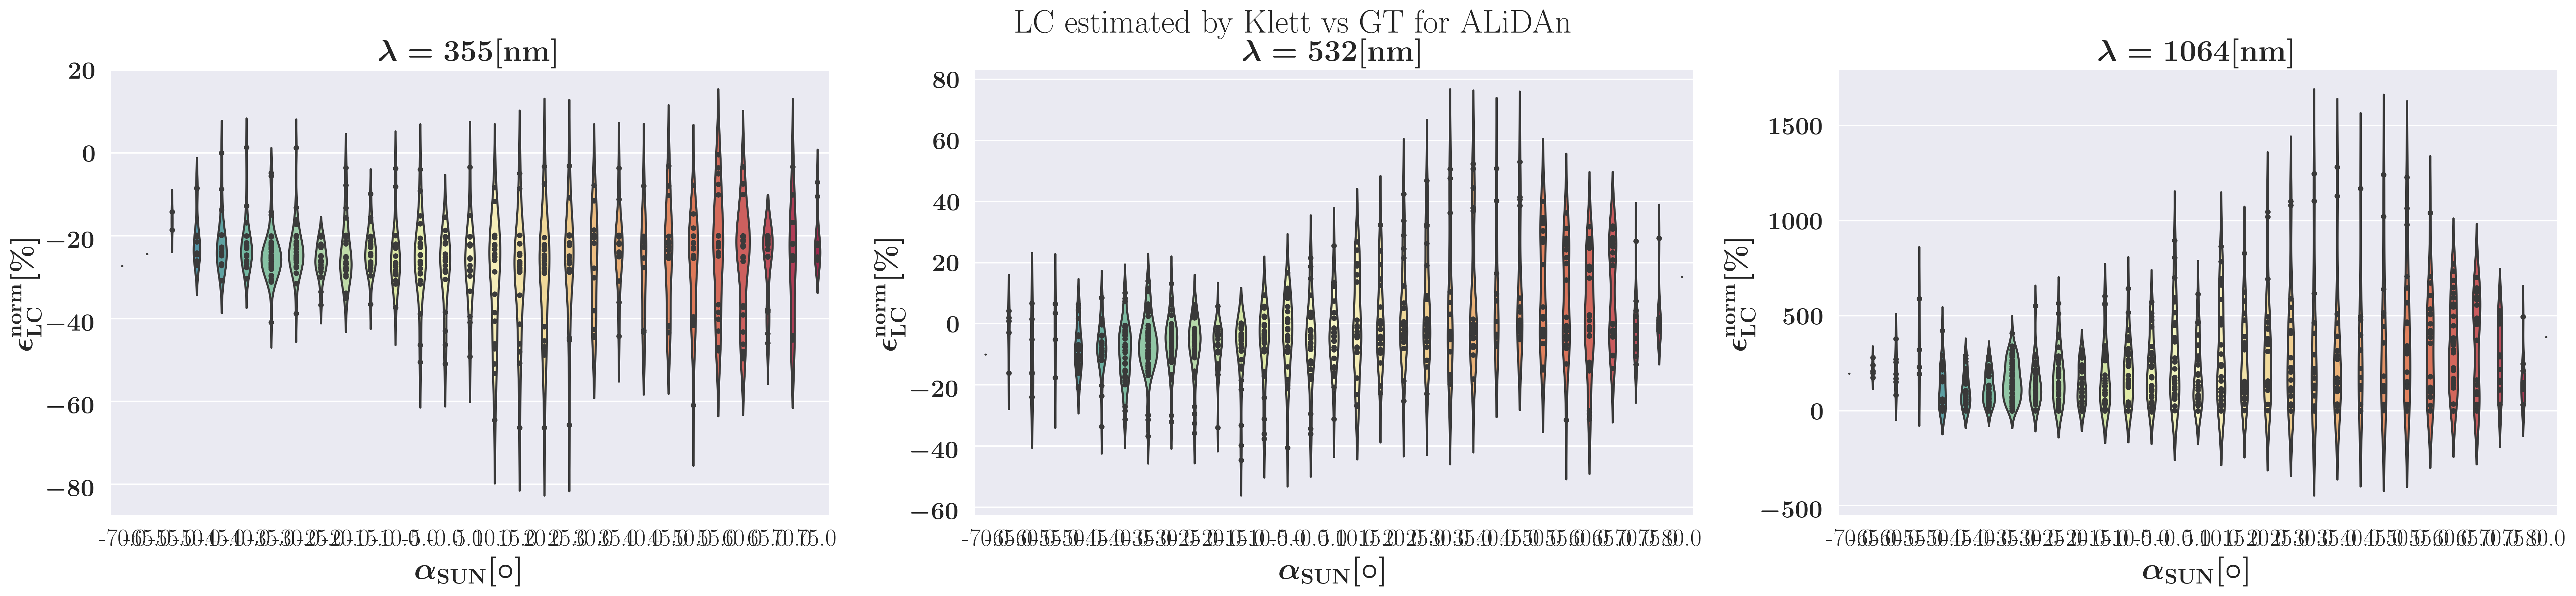

In [9]:
sns.set_palette(sns.color_palette("flare_r"))
#import seaborn as sns
cali_method = 'Klett_Method' # 'AOD_Constrained'
method_df = int_df[int_df['cali_method']==cali_method]
fig,axes = plt.subplots(nrows=1, ncols=len(wavelengths), figsize=(32,6))
for wavelength, ax in zip(wavelengths, axes.ravel()):
    wav_int_df = int_df[int_df['wavelength']==wavelength]
    sns.violinplot(ax=ax, data =wav_int_df[wav_int_df['cali_method']==cali_method],#  grp_wavelength[1],
                   x= 'quant_angle', #'QAngle',
                   y='relative_err',# 'relative_err',
                   palette="Spectral_r",
                   #hue= 'sun_elevation_mid', # 'cali_method',split=True,
                   scale="count", inner="points", label = 'a').\
        set(xlabel= r'$\alpha_{\rm SUN}[\circ]$',
            ylabel = r'$\epsilon_{\rm LC}^{\rm norm}[\%]$',
            title=rf'$\lambda={wavelength}[\rm nm]$')
stitle_violin =f"{cali_method.replace('_Method',' method')} Normalized error for {pollyType}"
plt.suptitle(stitle)
plt.show()
fpath =f'violin_stats_{polly_type}.{fig_type}'
fig.savefig(fpath, bbox_inches='tight', format=fig_type, dpi=1000)

In [10]:
group_days = int_df.groupby('date')
for g in group_days[0]:
    #print(g)
    sns.relplot(data = g[1], x='start_time_period', y='relative_err', hue='wavelength')
    sns.lineplot(data = g[1], x='start_time_period', y='relative_err', hue='wavelength')
    sns.lineplot(data = g[1], x='start_time_period', y='absolute_relative_err', hue='wavelength')
    plt.show()

KeyError: 'Column not found: 0'